In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from datetime import datetime
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [26]:
# Global Variables
target_col = 'WindSpeed 50'
train_percent = 0.75
n_past = 100
n_future = 24
n_features = 4

In [27]:
# Get data from CSV
def custom_date_parser(x): return datetime.strptime(x, "%Y %m %d %H")

dataset = pd.read_csv('MUP_dataset.csv', header=12, parse_dates=[
                      ['YEAR', 'MO', 'DY', 'HR']], date_parser=custom_date_parser, index_col=0)
dataset.index.name ='datetime'
dataset.columns = ['Pressure', 'WindSpeed 50', 'WindSpeed 10', 'Temperature']
print(dataset.head(5))


                     Pressure  WindSpeed 50  WindSpeed 10  Temperature
datetime                                                              
2016-01-01 05:00:00     98.49          6.54          3.38        18.79
2016-01-01 06:00:00     98.57          5.91          3.48        19.26
2016-01-01 07:00:00     98.66          5.74          4.70        21.07
2016-01-01 08:00:00     98.72          7.67          6.18        22.94
2016-01-01 09:00:00     98.72          8.40          6.94        24.27


In [28]:
dataset = dataset.replace('?', np.nan)
dataset.isnull().sum()


Pressure        0
WindSpeed 50    0
WindSpeed 10    0
Temperature     0
dtype: int64

In [29]:
def fill_missing(values):
    one_day = 60*24
    for row in range(dataset.shape[0]):
        for col in range(dataset.shape[1]):
            if np.isnan(values[row][col]):
                values[row, col] = values[row-one_day, col]


dataset = dataset.astype('float32')
fill_missing(dataset.values)
dataset.isnull().sum()

Pressure        0
WindSpeed 50    0
WindSpeed 10    0
Temperature     0
dtype: int64

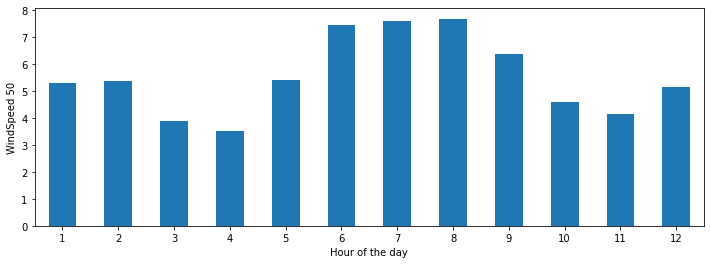

In [30]:
fig, axs = plt.subplots(figsize=(12, 4))
dataset.groupby(dataset.index.month)[
    'WindSpeed 50'].mean().plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Hour of the day")
plt.ylabel(target_col)
plt.show()

In [31]:
# To evaluation losses
def evalution_losses(y_true, y_pred):
    print('Evaluation metric results:-')
    print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(mean_squared_error(y_true, y_pred))}')

In [32]:
# pass model history here 
def plotModelLoss(model_history):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title("E1D1 Model Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Valid'])
    plt.show()

In [33]:
def processData(dataset,target,start,end,window,horizon):
    X = []
    y = []
    start = start+window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start,end):
        indicex = range(i-window,i)
        X.append(dataset[indicex])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [34]:
X_scaler = MinMaxScaler(feature_range=(-1,1))
Y_scaler = MinMaxScaler(feature_range=(-1,1))
X_data = X_scaler.fit_transform(dataset[['Pressure','WindSpeed 50','WindSpeed 10','Temperature']])
Y_data = Y_scaler.fit_transform(dataset[[target_col]])
X_data.shape,Y_data.shape

((52608, 4), (52608, 1))

In [35]:
TRAIN_SPLIT = int(len(X_data)*0.75)
x_train, y_train = processData(X_data, Y_data, 0, TRAIN_SPLIT, n_past, n_future)
x_test, y_test = processData(X_data, Y_data, TRAIN_SPLIT, None, n_past, n_future)

In [36]:
def lstm():
    lstm_model = tf.keras.models.Sequential(
        [   
            tf.keras.layers.LSTM(200,input_shape =x_train.shape[-2:]),
            tf.keras.layers.Dense(48, activation="sigmoid"),
            tf.keras.layers.Dense(48, activation="tanh"),
            tf.keras.layers.Dense(24, activation="sigmoid"),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Dense(units=n_future),
        ],
    )
    lstm_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
    lstm_model.summary()
    return lstm_model



In [37]:
def mlp():
    mlp_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(200,input_shape =x_train.shape[-2:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation="tanh"),
        tf.keras.layers.Dense(72, activation="tanh"),
        tf.keras.layers.Dense(36, activation="tanh"),
        tf.keras.layers.Dense(36, activation="tanh"),
        tf.keras.layers.Dense(36, activation="tanh"),
        tf.keras.layers.Dense(24, activation="tanh"),
        tf.keras.layers.Dense(units=n_future),
    ])
    mlp_model.compile(optimizer="adam", loss="mse")
    mlp_model.summary()
    return mlp_model

In [38]:
currentModel = lstm()
history = currentModel.fit(x_train,y_train,
    epochs=25,
    batch_size=32,
    validation_data=(x_test,y_test),
    verbose=1,
)
currentModel.save('lstm_model')
predictionOutput = currentModel.predict(x_test)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-04-19 17:56:15.965440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-19 17:56:15.966191: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               164000    
                                                                 
 dense (Dense)               (None, 48)                9648      
                                                                 
 dense_1 (Dense)             (None, 48)                2352      
                                                                 
 dense_2 (Dense)             (None, 24)                1176      
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
Total params: 177,776
Trainable params: 177,776
Non-trai

2022-04-19 17:56:17.134053: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-19 17:56:17.840100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 17:56:17.999928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 17:56:20.805098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1230/1230 [==============================] - ETA: 0s - loss: 0.0330

2022-04-19 17:56:51.784017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 17:56:51.830657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1230/1230 [==============================] - 40s 29ms/step - loss: 0.0330 - val_loss: 0.0118
Epoch 2/25
1230/1230 [==============================] - 35s 28ms/step - loss: 0.0106 - val_loss: 0.0086
Epoch 3/25
1230/1230 [==============================] - 36s 29ms/step - loss: 0.0093 - val_loss: 0.0076
Epoch 4/25
1230/1230 [==============================] - 37s 30ms/step - loss: 0.0081 - val_loss: 0.0066
Epoch 5/25
1230/1230 [==============================] - 35s 29ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 6/25
1230/1230 [==============================] - 40s 33ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 7/25
1230/1230 [==============================] - 36s 30ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 8/25
1230/1230 [==============================] - 38s 31ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 9/25
1230/1230 [==============================] - 43s 35ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 10/25
1230/1230 [==============================] - 37s 30ms/step - lo

2022-04-19 18:12:17.944077: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: lstm_model/assets


INFO:tensorflow:Assets written to: lstm_model/assets
2022-04-19 18:12:21.411430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-19 18:12:21.488372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [39]:
predictionOutput

array([[-0.2835846 , -0.27398375, -0.26962978, ..., -0.35266548,
        -0.3405497 , -0.33039683],
       [-0.24376428, -0.2421701 , -0.24875167, ..., -0.32631558,
        -0.30871186, -0.2970799 ],
       [-0.24213253, -0.24978435, -0.26670295, ..., -0.30097494,
        -0.2822932 , -0.27324647],
       ...,
       [-0.5438957 , -0.5499939 , -0.5594866 , ..., -0.5108126 ,
        -0.51344466, -0.5197284 ],
       [-0.54744124, -0.55277187, -0.56094325, ..., -0.5066196 ,
        -0.5109992 , -0.5183333 ],
       [-0.5183975 , -0.52392334, -0.53351367, ..., -0.5011163 ,
        -0.50383794, -0.5094687 ]], dtype=float32)

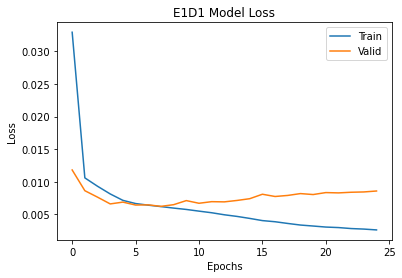

In [40]:
plotModelLoss(history)

In [41]:
evalution_losses()

TypeError: evalution_losses() missing 2 required positional arguments: 'y_true' and 'y_pred'